In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()

from scipy import stats
from scipy.stats import mannwhitneyu
import numpy as np
import matplotlib.pyplot as plt
from auditory_cortex.neural_data import NormalizerCalculator
from auditory_cortex.neural_data import create_neural_metadata, create_neural_dataset

In [2]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

stimuli = ['mVocs', 'timit']
stim_wise_tuned_sess_channels = {s:{} for s in stimuli}
stim_wise_session_null_dist = {s:{} for s in stimuli}
stim_wise_session_norm_dist = {s:{} for s in stimuli}

In [ ]:
bin_width = 20
p_value = 0.05
for mVocs in [True, False]:
    stim = 'mVocs' if mVocs else 'timit'
    tuned_channels = []
    all_p_values = []
    highly_tuned_channels = []
    all_p_values = []
    for session in sessions:
        shifted_null = norm_obj.get_normalizer_null_dist_using_random_shifts(
            session, bin_width=bin_width, mVocs=mVocs, force_redo=False
        )
        norm_dist = norm_obj.get_normalizer_for_session(
            session, bin_width=bin_width, mVocs=mVocs
        ) 
        stim_wise_session_null_dist[stim][session] = shifted_null
        # stim_wise_session_norm_dist[stim][session] = norm_dist
    
        # shifted_null = stim_wise_session_null_dist[stim][session]
        # norm_dist = stim_wise_session_norm_dist[stim][session]
        tuned_channels = []
        for ch in range(shifted_null.shape[1]):
            dist1 = norm_dist[:,ch]
            dist2 = shifted_null[:,ch]
            stat, p = mannwhitneyu(dist1, dist2, alternative='greater')  # dist1 > dist2
            all_p_values.append(p)
            if p < p_value:
                tuned_channels.append(ch)
        stim_wise_tuned_sess_channels[stim][session] = tuned_channels
    all_p_values = np.array(all_p_values) 

### number of tuned channels

In [12]:
stim_wise_sess_ch_lists = {stim:{} for stim in stimuli}
total_tuned = {stim:0 for stim in stimuli}
for stim in stimuli:
    neural_areas = ['core', 'non-primary']
    sessions = metadata.get_all_available_sessions()
    stim_wise_sess_ch_lists[stim] = {area:[] for area in neural_areas}
    
    print(f'Stimulus: {stim}')
    for area in neural_areas:
        area_sessions = metadata.get_all_sessions(area)
        # not all sessions are available..
        area_sessions = sessions[np.isin(sessions, area_sessions)]
        area_tuned = 0
        for sess in area_sessions:
            num_channels = len(stim_wise_tuned_sess_channels[stim][sess])
            area_tuned += num_channels
            if num_channels == 0:
                continue
            sess_ch_list = [f'{sess}_{ch}' for ch in stim_wise_tuned_sess_channels[stim][sess]]
            stim_wise_sess_ch_lists[stim][area].extend(sess_ch_list)
        total_tuned[stim] += area_tuned
        print(f'Total tuned channels in {area}: {area_tuned}')
    print(f'Total tuned channels in all areas: {total_tuned[stim]}')

Stimulus: mVocs
Total tuned channels in core: 701
Total tuned channels in non-primary: 530
Total tuned channels in all areas: 1231
Stimulus: timit
Total tuned channels in core: 707
Total tuned channels in non-primary: 488
Total tuned channels in all areas: 1195


In [ ]:
for area in ['core', 'non-primary']:
    print(f'Area: {area}')
    list_tuned = {}
    for stim in ['timit', 'mVocs']:
        list_tuned[stim] = stim_wise_sess_ch_lists[stim][area]
        print(f"\t Tuned for {stim}: {len(list_tuned[stim])}")
    tuned_both = set(list_tuned['mVocs']).intersection(set(list_tuned['timit']))
    print(f"\t Tuned for both: {len(tuned_both)}")
    print('---')

Area: core
	 Tuned for timit: 707
	 Tuned for mVocs: 701
	 Tuned for both: 580
---
Area: non-primary
	 Tuned for timit: 488
	 Tuned for mVocs: 530
	 Tuned for both: 341
---


### number of highly-tuned

In [ ]:
gap = 0.5
stim_wise_highly_tuned = {stim:{} for stim in stimuli}
for stim in stimuli:
    for session in sessions:
        norm_dist = stim_wise_session_norm_dist[stim][session]
        shifted_null = stim_wise_session_null_dist[stim][session]

        norm_means = np.mean(norm_dist, axis=0)
        null_means = np.mean(shifted_null, axis=0)

        null_std = np.std(shifted_null, axis=0)
        thresh = null_means + (gap * null_std)
        highly_tuned_chs = np.where(norm_means > thresh)[0]
        stim_wise_highly_tuned[stim][session] = highly_tuned_chs

In [ ]:
print(f"Gap: {gap}")
stim_wise_sess_ch_lists = {stim:{} for stim in stimuli}
total_highly_tuned = {stim:0 for stim in stimuli}
for stim in ['timit', 'mVocs']:
    neural_areas = ['core', 'non-primary']
    sessions = metadata.get_all_available_sessions()
    stim_wise_sess_ch_lists[stim] = {area:[] for area in neural_areas}
    
    print(f'Stimulus: {stim}')
    for area in neural_areas:
        area_sessions = metadata.get_all_sessions(area)
        # not all sessions are available..
        area_sessions = sessions[np.isin(sessions, area_sessions)]
        area_tuned = 0
        for sess in area_sessions:
            num_channels = len(stim_wise_highly_tuned[stim][sess])
            area_tuned += num_channels
            if num_channels == 0:
                continue
            sess_ch_list = [f'{sess}_{ch}' for ch in stim_wise_highly_tuned[stim][sess]]
            stim_wise_sess_ch_lists[stim][area].extend(sess_ch_list)
        total_highly_tuned[stim] += area_tuned
        print(f'Total highly tuned channels in {area}: {area_tuned}')
    print(f'Total highly tuned channels in all areas: {total_highly_tuned[stim]}')

Gap: 0.3
Stimulus: timit
Total highly tuned channels in core: 348
Total highly tuned channels in non-primary: 150
Total highly tuned channels in all areas: 498
Stimulus: mVocs
Total highly tuned channels in core: 349
Total highly tuned channels in non-primary: 246
Total highly tuned channels in all areas: 595


In [ ]:
print(f"Gap: {gap}")
for area in ['core', 'non-primary']:
    print(f'Area: {area}')
    list_tuned = {}
    for stim in ['timit', 'mVocs']:
        list_tuned[stim] = stim_wise_sess_ch_lists[stim][area]
        print(f"\t Highly tuned for {stim}: {len(list_tuned[stim])}")
    tuned_both = set(list_tuned['mVocs']).intersection(set(list_tuned['timit']))
    print(f"\t Highly tuned for both: {len(tuned_both)}")
    print('---')

Gap: 0.3
Area: core
	 Highly tuned for timit: 348
	 Highly tuned for mVocs: 349
	 Highly tuned for both: 282
---
Area: non-primary
	 Highly tuned for timit: 150
	 Highly tuned for mVocs: 246
	 Highly tuned for both: 120
---


### mean vs medians

In [53]:
bin_width = 50
mVocs = False
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
num_samples = {}
all_differences = []
for session in sessions:
    sess_norm_dist =  session_norm_dist[session]
    mean = np.mean(sess_norm_dist, axis=0)
    median = np.median(sess_norm_dist, axis=0)
    diff = mean - median
    all_differences.extend(diff)
    sess_wise_means[session] = mean
    sess_wise_medians[session] = median
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)
    num_samples[session] = sess_norm_dist.shape[0]

Text(0.5, 1.0, 'Mean - Median across all sessions')

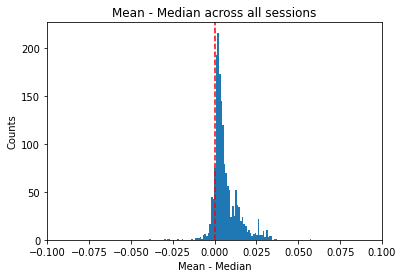

In [ ]:
plt.hist(all_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title('Mean - Median across all channels')

plot.savefig('mean_median_diff.png')


### highly-tuned

In [ ]:
tuned_channels = []
all_p_values = []
highly_tuned_channels = []
std_deviations_away = [0.1, 0.3, 1.0]
total_highly_tuned = {s:0 for s in std_deviations_away}
total_highly_tuned_medians = {s:0 for s in std_deviations_away}
highly_tuned_sess_channels = {s:{} for s in std_deviations_away}
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    for s in std_deviations_away:
        thresh = null_means + (s * null_std)
        highly_tuned = np.where(norm_means > thresh)[0]
        total_highly_tuned[s] += len(highly_tuned)
        highly_tuned_sess_channels[s][session] = highly_tuned

        thresh = null_medians + (s * null_std)
        highly_tuned = np.where(norm_medians > thresh)[0]
        total_highly_tuned_medians[s] += len(highly_tuned)

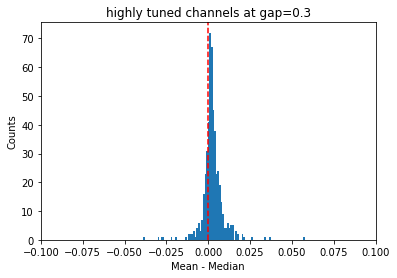

In [71]:
gap = 0.3
highly_tuned_means = []
highly_tuned_medians = []
sess_wise_highly_tuned = highly_tuned_sess_channels[gap]
for sess in sessions:
    if sess in sess_wise_highly_tuned.keys():
        ch_ids = np.array(sess_wise_highly_tuned[sess])
        mean = sess_wise_means[sess][ch_ids]
        median = sess_wise_medians[sess][ch_ids]

        highly_tuned_means.extend(mean)
        highly_tuned_medians.extend(median)
highly_tuned_differences = np.array(highly_tuned_means) - np.array(highly_tuned_medians)
# plotting...
plt.hist(highly_tuned_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title(f'highly tuned channels at gap={gap}')
plt.show()

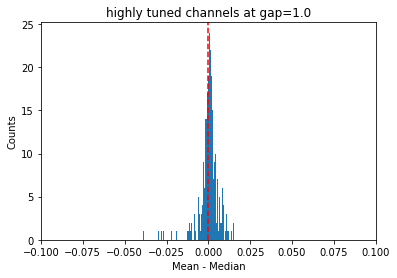

In [72]:
gap = 1.0
highly_tuned_means = []
highly_tuned_medians = []
sess_wise_highly_tuned = highly_tuned_sess_channels[gap]
for sess in sessions:
    if sess in sess_wise_highly_tuned.keys():
        ch_ids = np.array(sess_wise_highly_tuned[sess])
        mean = sess_wise_means[sess][ch_ids]
        median = sess_wise_medians[sess][ch_ids]

        highly_tuned_means.extend(mean)
        highly_tuned_medians.extend(median)
highly_tuned_differences = np.array(highly_tuned_means) - np.array(highly_tuned_medians)
# plotting...
plt.hist(highly_tuned_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlim(-0.1, 0.1)
plt.xlabel('Mean - Median')
plt.ylabel('Counts')
plt.title(f'highly tuned channels at gap={gap}')
plt.show()

## Shifted Null distribution...

In [2]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

In [ ]:
bin_width = 50
mVocs = False
p_value = 0.05
tuned_channels = []
all_p_values = []
highly_tuned_channels = []
session_null_dist = {}
session_norm_dist = {}
for session in sessions:
    shifted_null = norm_obj.get_normalizer_null_dist_using_random_shifts(
        session, bin_width=bin_width, mVocs=mVocs, force_redo=False
    )
    norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    ) 
    session_null_dist[session] = shifted_null
    session_norm_dist[session] = norm_dist
#     for ch in range(shifted_null.shape[1]):
#         dist1 = norm_dist[:,ch]
#         dist2 = shifted_null[:,ch]
#         stat, p = mannwhitneyu(dist1, dist2, alternative='greater')  # dist1 > dist2
#         all_p_values.append(p)
#         if p < p_value:
#             tuned_channels.append(f'{session}-{ch:02d}')
#         thresh = np.percentile(dist2, 85)
#         if np.median(dist1) > thresh:
#             highly_tuned_channels.append(f'{session}-{ch:02d}')

# all_p_values = np.array(all_p_values)    

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180413, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180420, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180501, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180502, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180613, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180622, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180627, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-180717, bw-50, mVocs=False
INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalize

In [ ]:
tuned_channels = []
all_p_values = []
highly_tuned_channels = []

std_deviations_away = np.linspace(0, 2.5, 26)
total_highly_tuned = {s:0 for s in std_deviations_away}
total_highly_tuned_medians = {s:0 for s in std_deviations_away}
for session in sessions:
    norm_dist = session_norm_dist[session]
    shifted_null = session_null_dist[session]

    norm_means = np.mean(norm_dist, axis=0)
    null_means = np.mean(shifted_null, axis=0)

    norm_medians = np.median(norm_dist, axis=0)
    null_medians = np.median(shifted_null, axis=0)

    null_std = np.std(shifted_null, axis=0)

    for s in std_deviations_away:
        thresh = null_means + (s * null_std)
        highly_tuned = np.where(norm_means > thresh)[0]
        total_highly_tuned[s] += len(highly_tuned)

        thresh = null_medians + (s * null_std)
        highly_tuned = np.where(norm_medians > thresh)[0]
        total_highly_tuned_medians[s] += len(highly_tuned)


In [6]:
std_deviations_away

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5])

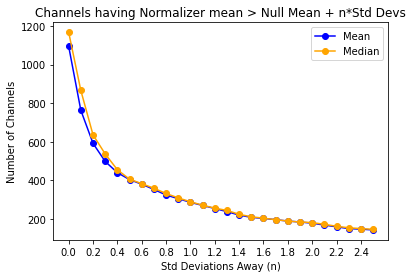

In [ ]:
plt.plot(std_deviations_away, [total_highly_tuned[s] for s in std_deviations_away], marker='o', color='blue', label='Mean')
plt.plot(std_deviations_away, [total_highly_tuned_medians[s] for s in std_deviations_away], marker='o', color='orange', label='Median')
plt.xticks(std_deviations_away[::2])
plt.xlabel('std deviations away (n)')
plt.ylabel('Number of channels')
plt.title('Channels having Normalizer mean > Null Mean + n*Std Devs')
plt.legend()
plt.show()

In [10]:
total_highly_tuned[0.30000000000000004]

537

In [11]:
total_highly_tuned[0.5]

406

In [12]:
total_highly_tuned[1]

289

In [21]:
total_highly_tuned

{0: 1095,
 0.25: 542,
 0.5: 404,
 0.75: 343,
 1: 286,
 1.25: 249,
 1.5: 208,
 1.75: 191,
 2: 178,
 2.25: 155,
 2.5: 143}

In [16]:
# median > median 
print(f"highly tuned channels: {total_highly_tuned}")

highly tuned channels: 1168


In [14]:
# mean > mean 
print(f"highly tuned channels: {total_highly_tuned}")

highly tuned channels: 1095


In [18]:
# mean > mean + 1 * std
print(f"highly tuned channels: {total_highly_tuned}")

highly tuned channels: 286


In [12]:
# mean > mean + 2 * std
print(f"highly tuned channels: {total_highly_tuned}")

highly tuned channels: 178


##### threshold mean

##### medians

In [ ]:
# percentile..50
len(highly_tuned_channels)

1168

In [6]:
# percentile..80
len(highly_tuned_channels)

319

In [8]:
# percentile..85
len(highly_tuned_channels)

273

In [ ]:
# percentile..90
len(highly_tuned_channels)

225

In [ ]:
# percentile..95
len(highly_tuned_channels)

188

In [22]:
len(tuned_channels)

1045

In [23]:

np.where(all_p_values < 1e-2)[0].shape

(1037,)

In [24]:
np.where(all_p_values < 1e-5)[0].shape

(1013,)

In [ ]:
bin_width = 50
mVocs = False
session = 200206
shifted_null = norm_obj.get_normalizer_null_dist_using_random_shifts(
    session, bin_width=bin_width, mVocs=mVocs, num_itr=10000, force_redo=False
)

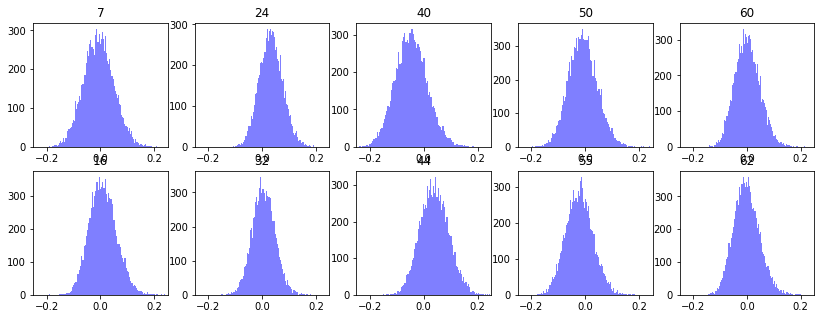

In [9]:
channels = [7, 16, 24, 32, 40, 44, 50, 55, 60, 62]
fig, axes = plt.subplots(2, len(channels)//2, figsize=(14, 5))
for i, ch in enumerate(channels):
    ax = axes[i%2, i//2]
    ax.set_title(f'{ch}')
    # ax.set_ylabel('Frequency')
    ax.hist(shifted_null[:,ch], bins=100, alpha=0.5, label='Shifted Null', color='blue')
    ax.set_xlim(-0.25, 0.25)

In [7]:
thresholds = []
for ch in range(shifted_null.shape[1]):
    thresholds.append(np.percentile(shifted_null[:,ch], 90))
    

(array([ 2.,  2.,  3.,  2.,  5., 17., 16., 11.,  2.,  4.]),
 array([-0.02236191, -0.00806898,  0.00622395,  0.02051688,  0.03480981,
         0.04910274,  0.06339567,  0.0776886 ,  0.09198153,  0.10627446,
         0.12056739]),
 <BarContainer object of 10 artists>)

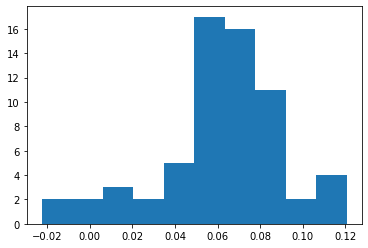

In [8]:
plt.hist(thresholds)

## Normalizers means vs medians

### timit

In [46]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-200206, bw-50, mVocs=False


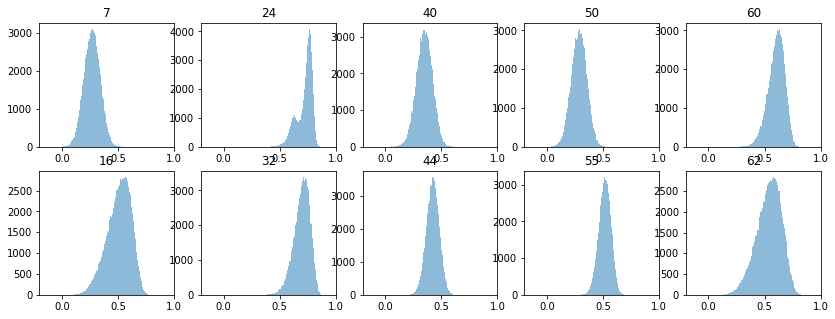

In [31]:
bin_width = 50
mVocs = False
session = 200206
sess_norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    )
channels = [7, 16, 24, 32, 40, 44, 50, 55, 60, 62]
fig, axes = plt.subplots(2, len(channels)//2, figsize=(14, 5))
for i, ch in enumerate(channels):
    ax = axes[i%2, i//2]
    ax.set_title(f'{ch}')
    # ax.set_ylabel('Frequency')
    ax.hist(sess_norm_dist[:,ch], bins=100, alpha=0.5, label='Normalized Activity')
    ax.set_xlim(-0.2, 1)
    # ax.legend()
# plt.hist(sess_norm_dist[:,ch], bins=100)
# plt.show()

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-200206, bw-50, mVocs=True


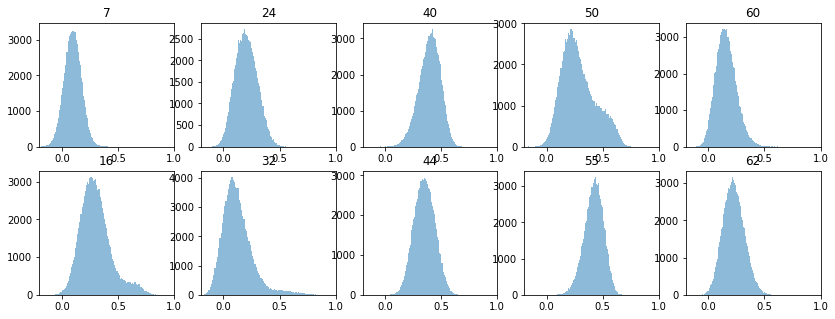

In [32]:
bin_width = 50
mVocs = True
session = 200206
sess_norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    )
channels = [7, 16, 24, 32, 40, 44, 50, 55, 60, 62]
fig, axes = plt.subplots(2, len(channels)//2, figsize=(14, 5))
for i, ch in enumerate(channels):
    ax = axes[i%2, i//2]
    ax.set_title(f'{ch}')
    # ax.set_ylabel('Frequency')
    ax.hist(sess_norm_dist[:,ch], bins=100, alpha=0.5, label='Normalized Activity')
    ax.set_xlim(-0.2, 1)
    # ax.legend()
# plt.hist(sess_norm_dist[:,ch], bins=100)
# plt.show()

In [34]:
sessions

array(['180413', '180420', '180501', '180502', '180613', '180622',
       '180627', '180717', '180719', '180720', '180724', '180728',
       '180730', '180731', '180807', '180808', '180810', '180814',
       '190604', '190605', '190606', '190703', '190726', '190801',
       '191113', '191115', '191121', '191125', '191206', '191209',
       '191210', '191211', '191219', '200205', '200206', '200207',
       '200212', '200213', '200219', '200313', '200318'], dtype='<U6')

In [48]:
bin_width = 50
mVocs = False
session = 191211
sess_norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    )
print(sess_norm_dist.shape)
med = np.median(sess_norm_dist, axis=0)
means = np.mean(sess_norm_dist, axis=0)
if mVocs:
    threshold = 0.089
else:
    threshold = 0.073
tuned_args = np.where(med > threshold)[0]
print(f"Highly tuned neurons: {tuned_args.shape[0]}")

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-191211, bw-50, mVocs=False
(100000, 61)
Highly tuned neurons: 0


In [49]:
diff = means - med

In [51]:
np.where(diff > 0.02)[0]

array([ 0,  4,  8, 13, 21, 39])

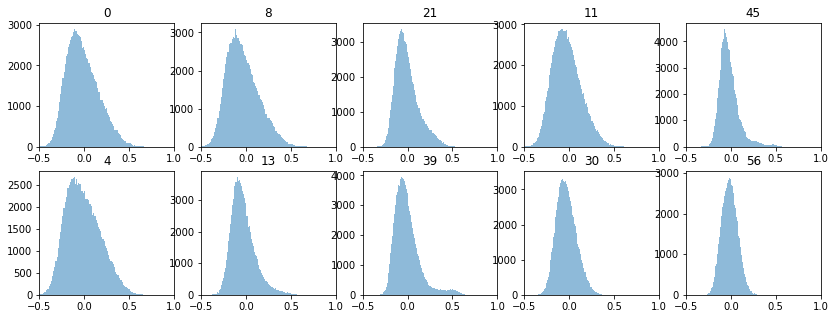

In [52]:
channels = np.random.randint(0, sess_norm_dist.shape[1], 10)
channels = [0, 4, 8, 13, 21,39, 11, 30, 45, 56]
fig, axes = plt.subplots(2, len(channels)//2, figsize=(14, 5))
for i, ch in enumerate(channels):
    ax = axes[i%2, i//2]
    ax.set_title(f'{ch}')
    # ax.set_ylabel('Frequency')
    ax.hist(sess_norm_dist[:,ch], bins=100, alpha=0.5, label='Normalized Activity')
    ax.set_xlim(-0.5, 1)
    # ax.legend()
# plt.hist(sess_norm_dist[:,ch], bins=100)
# plt.show()

INFO:auditory_cortex.neural_data.normalizer_calculator:Getting normalizer dist. for sess-200313, bw-50, mVocs=False
(100000, 63)
Highly tuned neurons: 13


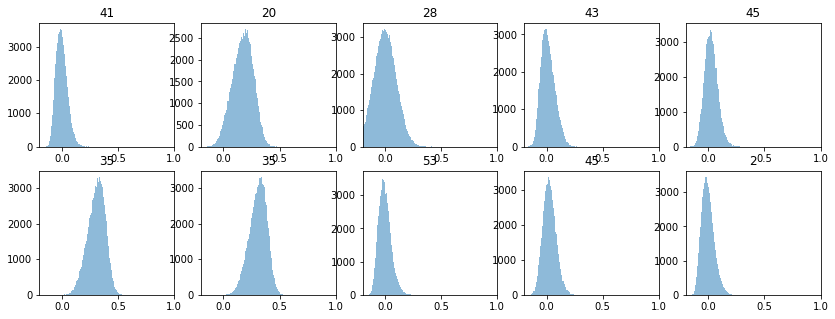

In [44]:
bin_width = 50
mVocs = False
session = 200313
sess_norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    )
print(sess_norm_dist.shape)
med = np.median(sess_norm_dist, axis=0)
if mVocs:
    threshold = 0.089
else:
    threshold = 0.073
tuned_args = np.where(med > threshold)[0]
print(f"Highly tuned neurons: {tuned_args.shape[0]}")

channels = np.random.randint(0, sess_norm_dist.shape[1], 10)
fig, axes = plt.subplots(2, len(channels)//2, figsize=(14, 5))
for i, ch in enumerate(channels):
    ax = axes[i%2, i//2]
    ax.set_title(f'{ch}')
    # ax.set_ylabel('Frequency')
    ax.hist(sess_norm_dist[:,ch], bins=100, alpha=0.5, label='Normalized Activity')
    ax.set_xlim(-0.2, 1)
    # ax.legend()
# plt.hist(sess_norm_dist[:,ch], bins=100)
# plt.show()

In [ ]:
bin_width = 50
mVocs = False
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
num_samples = {}
all_differences = []
for session in sessions:
    sess_norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    )
    mean = np.mean(sess_norm_dist, axis=0)
    median = np.median(sess_norm_dist, axis=0)
    diff = mean - median
    all_differences.extend(diff)
    sess_wise_means[session] = mean
    sess_wise_medians[session] = median
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)
    num_samples[session] = sess_norm_dist.shape[0]

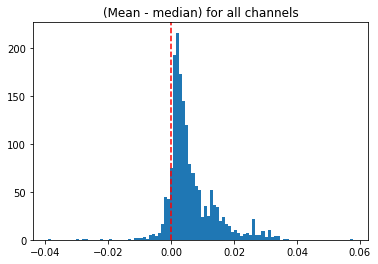

One-sided p-value: 3.0804157604580356e-189


In [ ]:
plt.hist(all_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('(Mean - median) for all channels')
plt.show()

# Example data
data = all_differences
# Perform one-sided t-test (H0: mean == 0, H1: mean > 0)
t_stat, p_value = stats.ttest_1samp(data, popmean=0)
# Since it's a one-sided test (mean > 0), divide p-value by 2
if t_stat > 0:
    one_sided_p = p_value / 2
else:
    one_sided_p = 1.0  # If t_stat <= 0, the p-value is 1 in one-sided test
print(f"One-sided p-value: {one_sided_p}")

In [ ]:
total_channels = 0
for sess, means in sess_wise_means.items():
    # print(f"Session: {sess}, shape: {means.shape}" )
    total_channels += len(means)
print(total_channels)

all_means = [means for sess, means in sess_wise_means.items()]
all_means = np.concatenate(all_means, axis=0)

all_medians = [medians for sess, medians in sess_wise_medians.items()]
all_medians = np.concatenate(all_medians, axis=0)

threshold = 0.073
highly_tuned_args = np.where(all_medians > threshold)[0]
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]
print(highly_tuned_args.shape)
highly_tuned_diff = highly_tuned_means - highly_tuned_medians

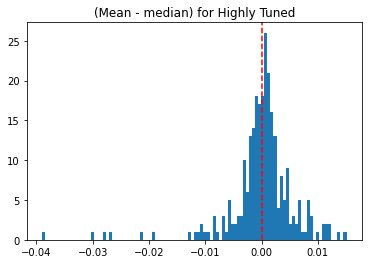

One-sided p-value: 1.0


In [ ]:
plt.hist(highly_tuned_diff, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('(Mean - median) for Highly Tuned')
plt.show()

data = highly_tuned_diff
# Perform one-sided t-test (H0: mean == 0, H1: mean > 0)
t_stat, p_value = stats.ttest_1samp(data, popmean=0)
# Since it's a one-sided test (mean > 0), divide p-value by 2
if t_stat > 0:
    one_sided_p = p_value / 2
else:
    one_sided_p = 1.0  # If t_stat <= 0, the p-value is 1 in one-sided test
print(f"One-sided p-value: {one_sided_p}")

In [5]:
threshold = 0.089
highly_tuned_args = np.where(all_medians > threshold)[0]
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]
print(highly_tuned_args.shape)

(314,)


#### earlier..

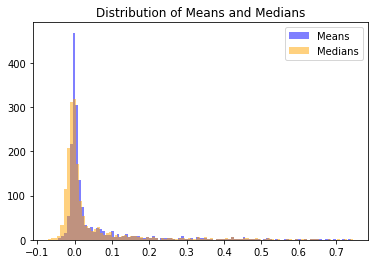

In [12]:
plt.hist(all_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(all_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Distribution of Means and Medians')
plt.legend()
plt.show()

In [13]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(all_means, all_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")


Statistic: 76889.0
P-value: 3.495880867188971e-226


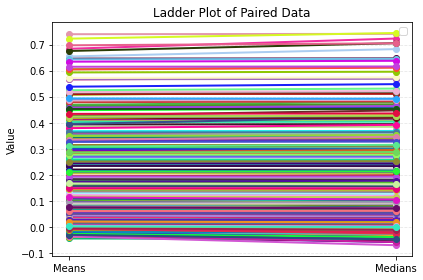

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = all_means
y = all_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Ladder Plot of Paired Data')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#### highly-tuned neurons

In [ ]:
norm_obj = NormalizerCalculator(dataset_name, session)

In [17]:
threshold_percentile = 90
null_dist = norm_obj.get_normalizer_null_dist_using_poisson(
                bin_width=bin_width, mVocs=mVocs,)
threshold = np.percentile(null_dist, threshold_percentile)  
print(f"Threshold for {threshold_percentile} percentile: {threshold}")

Threshold for 90 percentile: 0.07311907450200178


In [ ]:
highly_tuned_args = np.where(all_medians >= threshold)[0]
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]

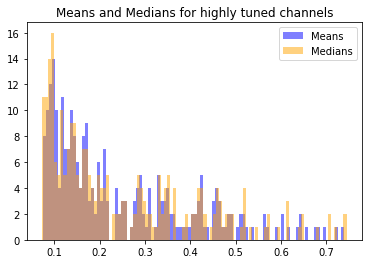

In [28]:
plt.hist(highly_tuned_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(highly_tuned_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Means and Medians for highly tuned channels')
plt.legend()
plt.show()

In [29]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(highly_tuned_means, highly_tuned_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 15471.0
P-value: 0.068908854510549


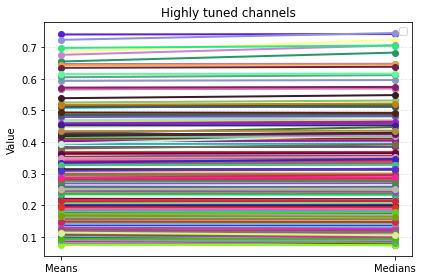

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = highly_tuned_means
y = highly_tuned_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Highly tuned channels')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
highly_tuned_args = np.where(all_means >= threshold)[0]
highly_tuned_args.shape

(274,)

### mVocs

In [ ]:
dataset_name = 'ucsf'
metadata = create_neural_metadata(dataset_name)
sessions = metadata.get_all_available_sessions()
norm_obj = NormalizerCalculator(dataset_name)

In [ ]:
bin_width = 50
mVocs = True
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
num_samples = {}
all_differences = []
for session in sessions:
    sess_norm_dist = norm_obj.get_normalizer_for_session(
        session, bin_width=bin_width, mVocs=mVocs
    )
    mean = np.mean(sess_norm_dist, axis=0)
    median = np.median(sess_norm_dist, axis=0)
    diff = mean - median
    all_differences.extend(diff)
    sess_wise_means[session] = mean
    sess_wise_medians[session] = median
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)
    num_samples[session] = sess_norm_dist.shape[0]

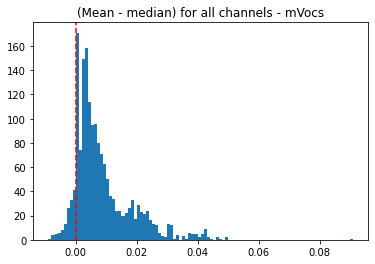

One-sided p-value: 3.900043484253148e-217


In [18]:
plt.hist(all_differences, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('(Mean - median) for all channels - mVocs')
plt.show()

# Example data
data = all_differences
# Perform one-sided t-test (H0: mean == 0, H1: mean > 0)
t_stat, p_value = stats.ttest_1samp(data, popmean=0)
# Since it's a one-sided test (mean > 0), divide p-value by 2
if t_stat > 0:
    one_sided_p = p_value / 2
else:
    one_sided_p = 1.0  # If t_stat <= 0, the p-value is 1 in one-sided test
print(f"One-sided p-value: {one_sided_p}")

In [19]:
total_channels = 0
for sess, means in sess_wise_means.items():
    # print(f"Session: {sess}, shape: {means.shape}" )
    total_channels += len(means)
print(total_channels)

all_means = [means for sess, means in sess_wise_means.items()]
all_means = np.concatenate(all_means, axis=0)

all_medians = [medians for sess, medians in sess_wise_medians.items()]
all_medians = np.concatenate(all_medians, axis=0)

threshold = 0.089
highly_tuned_args = np.where(all_medians > threshold)[0]
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]
print(highly_tuned_args.shape)
highly_tuned_diff = highly_tuned_means - highly_tuned_medians

1718
(314,)


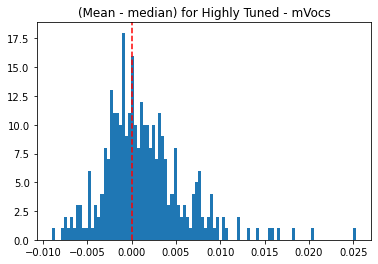

One-sided p-value: 8.350745708525217e-08


In [21]:
plt.hist(highly_tuned_diff, bins=100)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('(Mean - median) for Highly Tuned - mVocs')
plt.show()

data = highly_tuned_diff
# Perform one-sided t-test (H0: mean == 0, H1: mean > 0)
t_stat, p_value = stats.ttest_1samp(data, popmean=0)
# Since it's a one-sided test (mean > 0), divide p-value by 2
if t_stat > 0:
    one_sided_p = p_value / 2
else:
    one_sided_p = 1.0  # If t_stat <= 0, the p-value is 1 in one-sided test
print(f"One-sided p-value: {one_sided_p}")

In [ ]:
bin_width = 50
mVocs = True
sess_wise_means = {}
sess_wise_medians = {}
sess_wise_stds = {}
for session in sessions:
    norm_obj = NormalizerCalculator(dataset_name, session)
    sess_norm_dist = norm_obj.get_normalizer_for_session(
        bin_width=bin_width, mVocs=mVocs
    )

    sess_wise_means[session] = np.mean(sess_norm_dist, axis=0)
    sess_wise_medians[session] = np.median(sess_norm_dist, axis=0)
    sess_wise_stds[session] = np.std(sess_norm_dist, axis=0)

In [34]:
total_channels = 0
for sess, means in sess_wise_means.items():
    # print(f"Session: {sess}, shape: {means.shape}" )
    total_channels += len(means)
total_channels

1718

In [35]:
all_means = [means for sess, means in sess_wise_means.items()]
all_means = np.concatenate(all_means, axis=0)

all_medians = [medians for sess, medians in sess_wise_medians.items()]
all_medians = np.concatenate(all_medians, axis=0)

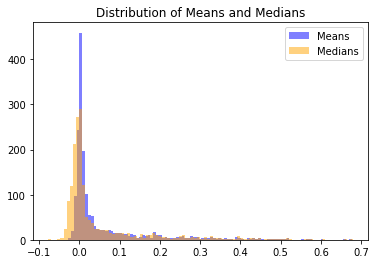

In [36]:
plt.hist(all_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(all_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Distribution of Means and Medians')
plt.legend()
plt.show()

In [37]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(all_means, all_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 36742.0
P-value: 7.280695780323757e-233


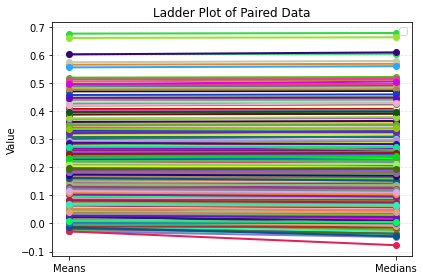

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = all_means
y = all_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Ladder Plot of Paired Data')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#### highly-tuned neurons

In [39]:
threshold_percentile = 90
null_dist = norm_obj.get_normalizer_null_dist_using_poisson(
                bin_width=bin_width, mVocs=mVocs,)
threshold = np.percentile(null_dist, threshold_percentile)  
print(f"Threshold for {threshold_percentile} percentile: {threshold}")

Threshold for 90 percentile: 0.08937104194148332


In [40]:
highly_tuned_args = np.where(all_medians >= threshold)[0]
print("Highly tuned channels:", highly_tuned_args.shape[0])
highly_tuned_medians = all_medians[highly_tuned_args]
highly_tuned_means = all_means[highly_tuned_args]

Highly tuned channels: 312


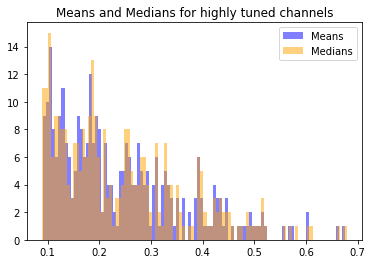

In [41]:
plt.hist(highly_tuned_means, color='blue', alpha=0.5, label='Means', bins=100)
plt.hist(highly_tuned_medians, color='orange', alpha=0.5, label='Medians', bins=100)
plt.title('Means and Medians for highly tuned channels')
plt.legend()
plt.show()

In [42]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(highly_tuned_means, highly_tuned_medians)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 17749.0
P-value: 2.922499979827881e-05


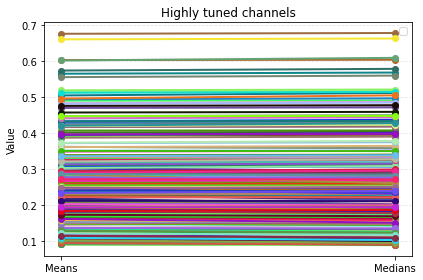

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example paired data
x = highly_tuned_means
y = highly_tuned_medians

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Plot ladder plot with random colors
plt.figure(figsize=(6, 4))
for i in range(len(x)):
    color = np.random.rand(3,)  # random RGB color
    plt.plot([0, 1], [x[i], y[i]], marker='o', color=color, linewidth=2)

# # Optional: show mean lines
# plt.plot([0, 1], [np.mean(x), np.mean(y)], color='black', linestyle='--', label='Mean')

# Formatting
plt.xticks([0, 1], ['Means', 'Medians'])
plt.ylabel('Value')
plt.title('Highly tuned channels')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
highly_tuned_args = np.where(all_means >= threshold)[0]
highly_tuned_args.shape

(325,)